### USING LOGISTIC REGRESSION ANALYSIS

### Table of Contents

* [Import Libraries](#section_1)
* [Load the Dataset into Dataframe](#section_2)
* [Scrubbing the Data](#section_3)
* [Performing Feature Selection](#section_4)
* [Model Building](#section_5)
* [PreProcessing the Dataset](#section_6)
* [Fine-Tunning the Model](#section_7)
* [Build the Model](#section_5)
* [Evaluating the Model](#section_6)

## SECTION 1: IMPORT THE LIBRARIES

<a id="section_1"></a>

In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import linear_model
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import io
import plotly.offline as py#visualization
py.init_notebook_mode(connected=True)#visualization
import plotly.graph_objs as go#visualization
import plotly.tools as tls#visualization
import plotly.figure_factory as ff#visualization

## SECTION 2: Load The DataSet to DataFrame

<a id="section_2"></a>

#### Read the Data to Pandas DataFrame named Data

In [96]:
data = pd.read_csv('Telco_Customer_Churn.csv')

In [97]:
# Read first few rows
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [98]:
print ("Rows     : " ,data.shape[0])
print ("Columns  : " ,data.shape[1])
print ("\nFeatures : \n" ,data.columns.tolist())
print ("\nMissing values :  ", data.isnull().sum().values.sum())
print ("\nUnique values :  \n",data.nunique())

Rows     :  7043
Columns  :  21

Features : 
 ['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn']

Missing values :   0

Unique values :  
 customerID          7043
gender                 2
SeniorCitizen          2
Partner                2
Dependents             2
tenure                73
PhoneService           2
MultipleLines          3
InternetService        3
OnlineSecurity         3
OnlineBackup           3
DeviceProtection       3
TechSupport            3
StreamingTV            3
StreamingMovies        3
Contract               3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      1585
TotalCharges        6531
Churn                  2
dtype: int64


In [99]:
#Data Manipulation

#Replacing spaces with null values in total charges column
data['TotalCharges'] = data["TotalCharges"].replace(" ",np.nan)

#Dropping null values from total charges column which contain .15% missing data 
data = data[data["TotalCharges"].notnull()]
data = data.reset_index()[data.columns]

#convert to float type
data["TotalCharges"] = data["TotalCharges"].astype(float)

#replace 'No internet service' to No for the following columns
replace_cols = [ 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                'TechSupport','StreamingTV', 'StreamingMovies']
for i in replace_cols : 
    data[i]  = data[i].replace({'No internet service' : 'No'})
    
#replace values
data["SeniorCitizen"] = data["SeniorCitizen"].replace({1:"Yes",0:"No"})

#Tenure to categorical column
def tenure_lab(data) :
    
    if data["tenure"] <= 12 :
        return "Tenure_0-12"
    elif (data["tenure"] > 12) & (data["tenure"] <= 24 ):
        return "Tenure_12-24"
    elif (data["tenure"] > 24) & (data["tenure"] <= 48) :
        return "Tenure_24-48"
    elif (data["tenure"] > 48) & (data["tenure"] <= 60) :
        return "Tenure_48-60"
    elif data["tenure"] > 60 :
        return "Tenure_gt_60"
data["tenure_group"] = data.apply(lambda data:tenure_lab(data),
                                      axis = 1)

#Separating churn and non churn customers
churn     = data[data["Churn"] == "Yes"]
not_churn = data[data["Churn"] == "No"]

#Separating catagorical and numerical columns
Id_col     = ['customerID']
target_col = ["Churn"]
cat_cols   = data.nunique()[data.nunique() < 6].keys().tolist()
cat_cols   = [x for x in cat_cols if x not in target_col]
num_cols   = [x for x in data.columns if x not in cat_cols + target_col + Id_col]

In [100]:
data

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,tenure_group
0,7590-VHVEG,Female,No,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,Tenure_0-12
1,5575-GNVDE,Male,No,No,No,34,Yes,No,DSL,Yes,...,No,No,No,One year,No,Mailed check,56.95,1889.50,No,Tenure_24-48
2,3668-QPYBK,Male,No,No,No,2,Yes,No,DSL,Yes,...,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,Tenure_0-12
3,7795-CFOCW,Male,No,No,No,45,No,No phone service,DSL,Yes,...,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No,Tenure_24-48
4,9237-HQITU,Female,No,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,Tenure_0-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7027,6840-RESVB,Male,No,Yes,Yes,24,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.50,No,Tenure_12-24
7028,2234-XADUH,Female,No,Yes,Yes,72,Yes,Yes,Fiber optic,No,...,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.90,No,Tenure_gt_60
7029,4801-JZAZL,Female,No,Yes,Yes,11,No,No phone service,DSL,Yes,...,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No,Tenure_0-12
7030,8361-LTMKD,Male,Yes,Yes,No,4,Yes,Yes,Fiber optic,No,...,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.60,Yes,Tenure_0-12


In [101]:
from pivottablejs import pivot_ui
pivot_ui(data)

In [102]:
#cusomer attrition in tenure groups
tg_ch  =  churn["tenure_group"].value_counts().reset_index()
tg_ch.columns  = ["tenure_group","count"]
tg_nch =  not_churn["tenure_group"].value_counts().reset_index()
tg_nch.columns = ["tenure_group","count"]

#bar - churn
trace1 = go.Bar(x = tg_ch["tenure_group"]  , y = tg_ch["count"],
                name = "Churn Customers",
                marker = dict(line = dict(width = .5,color = "black")),
                opacity = .9)

#bar - not churn
trace2 = go.Bar(x = tg_nch["tenure_group"] , y = tg_nch["count"],
                name = "Non Churn Customers",
                marker = dict(line = dict(width = .5,color = "black")),
                opacity = .9)

layout = go.Layout(dict(title = "Customer Churning in tenure groups",
                        plot_bgcolor  = "rgb(243,243,243)",
                        paper_bgcolor = "rgb(243,243,243)",
                        xaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                     title = "tenure group",
                                     zerolinewidth=1,ticklen=5,gridwidth=2),
                        yaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                     title = "count",
                                     zerolinewidth=1,ticklen=5,gridwidth=2),
                       )
                  )
traces = [trace1,trace2]
fig  = go.Figure(data=traces,layout=layout)
py.iplot(fig)

In [103]:
data['InternetService'].unique()

array(['DSL', 'Fiber optic', 'No'], dtype=object)

In [104]:
data['Churn']

0        No
1        No
2       Yes
3        No
4       Yes
       ... 
7027     No
7028     No
7029     No
7030    Yes
7031     No
Name: Churn, Length: 7032, dtype: object

for i in range(len(data)):
    if data['Churn'][i] == 'No':
        data['Churn'][i] = 0
    else:
        data['Churn'][i] = 1

In [105]:
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,tenure_group
0,7590-VHVEG,Female,No,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,Tenure_0-12
1,5575-GNVDE,Male,No,No,No,34,Yes,No,DSL,Yes,...,No,No,No,One year,No,Mailed check,56.95,1889.50,No,Tenure_24-48
2,3668-QPYBK,Male,No,No,No,2,Yes,No,DSL,Yes,...,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,Tenure_0-12
3,7795-CFOCW,Male,No,No,No,45,No,No phone service,DSL,Yes,...,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No,Tenure_24-48
4,9237-HQITU,Female,No,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,Tenure_0-12


In [106]:
# Check the Number of Rows and Columns
data.shape

(7032, 22)

> The dataset contains 7032 rows and 22 Columns

## SECTION 3: Data Preprocessing

<a id="section_3"></a>

> Missing value imputation, data type conversion, standardization and renaming the column

In [107]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

#customer id col
Id_col     = ['customerID']
#Target columns
target_col = ["Churn"]
#categorical columns
cat_cols   = data.nunique()[data.nunique() < 6].keys().tolist()
cat_cols   = [x for x in cat_cols if x not in target_col]
#numerical columns
num_cols   = [x for x in data.columns if x not in cat_cols + target_col + Id_col]
#Binary columns with 2 values
bin_cols   = data.nunique()[data.nunique() == 2].keys().tolist()
#Columns more than 2 values
multi_cols = [i for i in cat_cols if i not in bin_cols]

#Label encoding Binary columns
le = LabelEncoder()
for i in bin_cols :
    data[i] = le.fit_transform(data[i])
    
#Duplicating columns for multi value columns
data = pd.get_dummies(data = data,columns = multi_cols )

#Scaling Numerical columns
std = StandardScaler()
scaled = std.fit_transform(data[num_cols])
scaled = pd.DataFrame(scaled,columns=num_cols)

#dropping original values merging scaled values for numerical columns
df_data_og = data.copy()
data = data.drop(columns = num_cols,axis = 1)
data = data.merge(scaled,left_index=True,right_index=True,how = "left")

In [108]:
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,PhoneService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,...,PaymentMethod_Electronic check,PaymentMethod_Mailed check,tenure_group_Tenure_0-12,tenure_group_Tenure_12-24,tenure_group_Tenure_24-48,tenure_group_Tenure_48-60,tenure_group_Tenure_gt_60,tenure,MonthlyCharges,TotalCharges
0,7590-VHVEG,0,0,1,0,0,0,1,0,0,...,1,0,1,0,0,0,0,-1.280248,-1.161694,-0.994194
1,5575-GNVDE,1,0,0,0,1,1,0,1,0,...,0,1,0,0,1,0,0,0.064303,-0.260878,-0.173740
2,3668-QPYBK,1,0,0,0,1,1,1,0,0,...,0,1,1,0,0,0,0,-1.239504,-0.363923,-0.959649
3,7795-CFOCW,1,0,0,0,0,1,0,1,1,...,0,0,0,0,1,0,0,0.512486,-0.747850,-0.195248
4,9237-HQITU,0,0,0,0,1,0,0,0,0,...,1,0,1,0,0,0,0,-1.239504,0.196178,-0.940457


In [109]:
summary = (df_data_og[[i for i in df_data_og.columns if i not in Id_col]].
           describe().transpose().reset_index())

summary = summary.rename(columns = {"index" : "feature"})
summary = np.around(summary,3)

val_lst = [summary['feature'], summary['count'],
           summary['mean'],summary['std'],
           summary['min'], summary['25%'],
           summary['50%'], summary['75%'], summary['max']]

trace  = go.Table(header = dict(values = summary.columns.tolist(),
                                line = dict(color = ['#506784']),
                                fill = dict(color = ['#119DFF']),
                               ),
                  cells  = dict(values = val_lst,
                                line = dict(color = ['#506784']),
                                fill = dict(color = ["lightgrey",'#F5F8FF'])
                               ),
                  columnwidth = [200,60,100,100,60,60,80,80,80])
layout = go.Layout(dict(title = "Variable Summary"))
figure = go.Figure(data=[trace],layout=layout)
py.iplot(figure)

### Feature Correlation 

In [110]:
#correlation
correlation = data.corr()
#tick labels
matrix_cols = correlation.columns.tolist()
#convert to array
corr_array  = np.array(correlation)

#Plotting
trace = go.Heatmap(z = corr_array,
                   x = matrix_cols,
                   y = matrix_cols,
                   colorscale = "Viridis",
                   colorbar   = dict(title = "Pearson Correlation coefficient",
                                     titleside = "right"
                                    ) ,
                  )

layout = go.Layout(dict(title = "Correlation Matrix for variables",
                        autosize = False,
                        height  = 720,
                        width   = 800,
                        margin  = dict(r = 0 ,l = 210,
                                       t = 25,b = 210,
                                      ),
                        yaxis   = dict(tickfont = dict(size = 9)),
                        xaxis   = dict(tickfont = dict(size = 9))
                       )
                  )

traces = [trace]
fig = go.Figure(data=traces,layout=layout)
py.iplot(fig)

In [111]:
# Checking missing values
data.isnull().any()

customerID                                 False
gender                                     False
SeniorCitizen                              False
Partner                                    False
Dependents                                 False
PhoneService                               False
OnlineSecurity                             False
OnlineBackup                               False
DeviceProtection                           False
TechSupport                                False
StreamingTV                                False
StreamingMovies                            False
PaperlessBilling                           False
Churn                                      False
MultipleLines_No                           False
MultipleLines_No phone service             False
MultipleLines_Yes                          False
InternetService_DSL                        False
InternetService_Fiber optic                False
InternetService_No                         False
Contract_Month-to-mo

Replace missing Data
missing_data = list(data[data['TotalCharges'] == " "].index)
print('Missing Data from TotalCharges Indexes :', missing_data , '\nTotal rows :', len(missing_data))
missing_data = list(data[data['TotalCharges'] == " "].index)

Convert TotalCharges to Numeric
data.TotalCharges = pd.to_numeric(data.TotalCharges, errors='coerce')

In [112]:
# Explore the data
data.describe()

,gender,SeniorCitizen,Partner,Dependents,PhoneService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,...,PaymentMethod_Electronic check,PaymentMethod_Mailed check,tenure_group_Tenure_0-12,tenure_group_Tenure_12-24,tenure_group_Tenure_24-48,tenure_group_Tenure_48-60,tenure_group_Tenure_gt_60,tenure,MonthlyCharges,TotalCharges
count,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,...,7032.000000,7032.000000,7032.000000,7032.00000,7032.000000,7032.000000,7032.000000,7.032000e+03,7.032000e+03,7.032000e+03
mean,0.504693,0.162400,0.482509,0.298493,0.903299,0.286547,0.344852,0.343857,0.290102,0.384386,...,0.336320,0.228100,0.309300,0.14562,0.226678,0.118316,0.200085,-1.214741e-16,9.652878e-17,-1.172113e-16
std,0.500014,0.368844,0.499729,0.457629,0.295571,0.452180,0.475354,0.475028,0.453842,0.486484,...,0.472483,0.419637,0.462238,0.35275,0.418712,0.323005,0.400092,1.000071e+00,1.000071e+00,1.000071e+00
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,-1.280248e+00,-1.547283e+00,-9.990692e-01
25%,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,-9.542963e-01,-9.709769e-01,-8.302488e-01
50%,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,-1.394171e-01,1.845440e-01,-3.908151e-01
75%,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,0.000000,1.000000,0.00000,0.000000,0.000000,0.000000,9.199259e-01,8.331482e-01,6.668271e-01
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.612573e+00,1.793381e+00,2.824261e+00


In [113]:
# Drop the customerID column
data.drop(labels=['customerID'], axis = 1, inplace=True)

# Change the Data types to Categorical
# Print the unique entries in the features
column_ex = ['MonthlyCharges', 'CustomerID', 'Tenure', 'TotalCharges']
for name in data.columns:
    if name not in column_ex:
        data[name] = data[name].astype('category').cat.codes

In [114]:
data.head()

,gender,SeniorCitizen,Partner,Dependents,PhoneService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,...,PaymentMethod_Electronic check,PaymentMethod_Mailed check,tenure_group_Tenure_0-12,tenure_group_Tenure_12-24,tenure_group_Tenure_24-48,tenure_group_Tenure_48-60,tenure_group_Tenure_gt_60,tenure,MonthlyCharges,TotalCharges
0,0,0,1,0,0,0,1,0,0,0,...,1,0,1,0,0,0,0,-1.280248,-1.161694,-0.994194
1,1,0,0,0,1,1,0,1,0,0,...,0,1,0,0,1,0,0,0.064303,-0.260878,-0.173740
2,1,0,0,0,1,1,1,0,0,0,...,0,1,1,0,0,0,0,-1.239504,-0.363923,-0.959649
3,1,0,0,0,0,1,0,1,1,0,...,0,0,0,0,1,0,0,0.512486,-0.747850,-0.195248
4,0,0,0,0,1,0,0,0,0,0,...,1,0,1,0,0,0,0,-1.239504,0.196178,-0.940457


In [115]:
data.shape[1]
#data.drop(labels=['CustomerID'], axis = 1, inplace = True)

34

## SECTION 4: Performing Feature Selection

<a id="section_4"></a>

We will be performing feature selection using a tree-based selection method that performs best on classification tasks

In [116]:
# Import RandomForestClassifier and train_test_split from sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
from sklearn.metrics import roc_auc_score,roc_curve,scorer
from sklearn.metrics import precision_score,recall_score
from sklearn.metrics import f1_score
from yellowbrick.classifier import DiscriminationThreshold

In [117]:
# make labels
labels = data['Churn']

In [118]:
# make train data
data.drop(labels=['Churn'], axis = 1, inplace=True)

In [120]:
labels.head()

0    0
1    0
2    1
3    0
4    1
Name: Churn, dtype: int32

In [122]:
data.columns

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'PaperlessBilling',
       'MultipleLines_No', 'MultipleLines_No phone service',
       'MultipleLines_Yes', 'InternetService_DSL',
       'InternetService_Fiber optic', 'InternetService_No',
       'Contract_Month-to-month', 'Contract_One year', 'Contract_Two year',
       'PaymentMethod_Bank transfer (automatic)',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check',
       'tenure_group_Tenure_0-12', 'tenure_group_Tenure_12-24',
       'tenure_group_Tenure_24-48', 'tenure_group_Tenure_48-60',
       'tenure_group_Tenure_gt_60', 'tenure', 'MonthlyCharges',
       'TotalCharges'],
      dtype='object')

In [124]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size = 0.15, random_state=123, stratify=labels)

In [125]:
# Fit the model using Random Forest classifier for feature Selection
forest = RandomForestClassifier(n_estimators=500, random_state = 1)
forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

In [126]:
# Call the Random Forest Feature_importances_ attribute to find important features
# and store it in variable named importances
importances = forest.feature_importances_

In [127]:
# Create variable features to store all the columns except the target Churn
features = data.columns
indices = np.argsort(importances)[::-1]

<function matplotlib.pyplot.show(*args, **kw)>

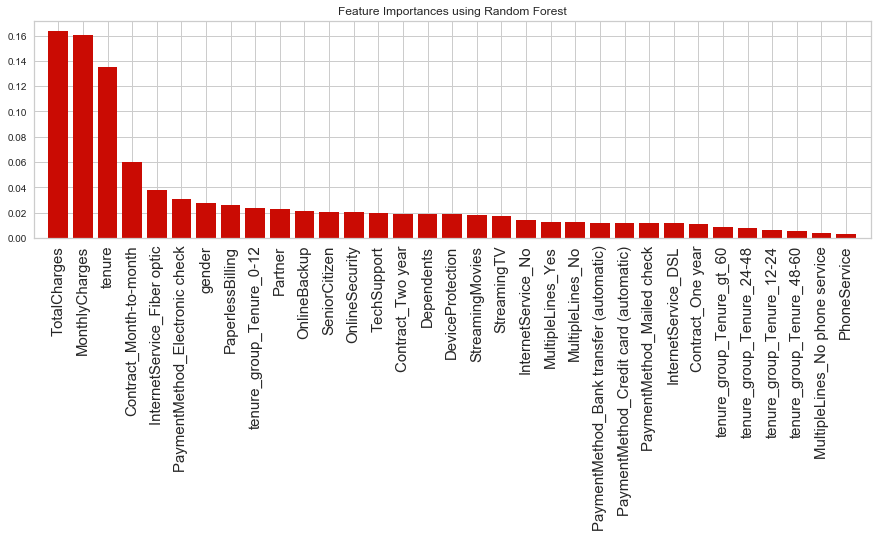

In [128]:
plt.figure(figsize=(15,4))
plt.title("Feature Importances using Random Forest")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="r", align="center")
plt.xticks(range(X_train.shape[1]), features[indices],
          rotation='vertical', fontsize=15)
plt.xlim([-1, X_train.shape[1]])
plt.show

From the figure above, we are going to pick the first seven most important features from the tree-based feature selection: **TotalCharges, MonthlyCharges, Tenure, Contract, PaymentMethod, OnlineSecurity, TechSupport**

In [135]:
features = ['TotalCharges', 'MonthlyCharges', 'tenure', 'Contract_Month-to-month', 
            'InternetService_Fiber optic', 'PaymentMethod_Electronic check', 'gender', 
            'PaperlessBilling', 'tenure_group_Tenure_0-12', 'Partner', 'OnlineBackup', 
            'SeniorCitizen', 'OnlineSecurity', 'TechSupport', 'Contract_Two year', 
            'Dependents', 'DeviceProtection', 'StreamingMovies']

## SECTION 5: Model Building

<a id="section_5"></a>

We are going to try out different kind of algorithm to build the prediction model. We will be using **Logistic Regression** as the base model 

### Using the statsmodel
****

In [136]:
# Import statsmodel
import statsmodels.api as sm

In [137]:
top18_features = ['TotalCharges', 'MonthlyCharges', 'tenure', 'Contract_Month-to-month', 
            'InternetService_Fiber optic', 'PaymentMethod_Electronic check', 'gender', 
            'PaperlessBilling', 'tenure_group_Tenure_0-12', 'Partner', 'OnlineBackup', 
            'SeniorCitizen', 'OnlineSecurity', 'TechSupport', 'Contract_Two year', 
            'Dependents', 'DeviceProtection', 'StreamingMovies']

In [138]:
logReg = sm.Logit(y_train.astype(float), X_train[top18_features].astype(float))
logistic_regression = logReg.fit()

Optimization terminated successfully.
         Current function value: 0.430096
         Iterations 8


In [139]:
# Obtain the Summary and the Parameters
logistic_regression.summary
logistic_regression.params

TotalCharges                      0.342775
MonthlyCharges                    1.548142
tenure                           -0.900304
Contract_Month-to-month           0.198131
InternetService_Fiber optic      -1.037712
PaymentMethod_Electronic check    0.297577
gender                           -0.205589
PaperlessBilling                  0.132647
tenure_group_Tenure_0-12          0.260046
Partner                          -0.141849
OnlineBackup                     -0.520370
SeniorCitizen                     0.214335
OnlineSecurity                   -0.846787
TechSupport                      -0.852436
Contract_Two year                -1.172605
Dependents                       -0.285073
DeviceProtection                 -0.458377
StreamingMovies                  -0.351710
dtype: float64

In [141]:
coef = logistic_regression.params
coef

TotalCharges                      0.342775
MonthlyCharges                    1.548142
tenure                           -0.900304
Contract_Month-to-month           0.198131
InternetService_Fiber optic      -1.037712
PaymentMethod_Electronic check    0.297577
gender                           -0.205589
PaperlessBilling                  0.132647
tenure_group_Tenure_0-12          0.260046
Partner                          -0.141849
OnlineBackup                     -0.520370
SeniorCitizen                     0.214335
OnlineSecurity                   -0.846787
TechSupport                      -0.852436
Contract_Two year                -1.172605
Dependents                       -0.285073
DeviceProtection                 -0.458377
StreamingMovies                  -0.351710
dtype: float64

In [147]:
# Create a function to compute the coefficient
coef = logistic_regression.params
def pred(coef, TotalCharges, MonthlyCharges, Tenure, Contract_Month, InternetService_Fiber,
         PaymentMethod_Electronic, gender, PaperlessBilling, tenure_group_Tenure_0, 
         Partner, OnlineBackup, SeniorCitizen, OnlineSecurity, TechSupport, Contract_Two, Dependents,
        DeviceProtection, StreamingMovies):
    return coef[0]*TotalCharges + coef[1]*MonthlyCharges + coef[2]*Tenure + coef[3]*Contract_Month 
    + coef[4]*InternetService_Fiber + coef[5]*PaymentMethod_Electronic + coef[6]*gender + coef[7]*PaperlessBilling
    + coef[8]*tenure_group_Tenure_0 + coef[9]*Partner + coef[10]*OnlineBackup + coef[11]*SeniorCitizen 
    + coef[12]*OnlineSecurity + coef[13]*TechSupport + coef[14]*Contract_Two + coef[15]*Dependents + coef[16]*DeviceProtection 
    + coef[17]*StreamingMovies

In [148]:
# Example: Calculate the chance of a customer churning by inputing the following values
# TotalCharges: 2000, MonthlyCharges: 56.32, Tenure: 34, Contract: 2, PaymentMethod: 2, OnlineSecurity: 1, TechSupport: 2

In [72]:
import numpy as np
output = pred(coef, 2000, 56.32, 34, 2, 2, 1, 2)
probability = np.exp(output) / (1 + np.exp(output))

In [73]:
probability

0.07701400670535927

The probability is approximately 0.077, which implies that a customer with a total charges of 2000 dollars, a monthly charge of 56.32 dollars with a tenure of 34, contract term of 2 years, pays by mailing check and has no online security with no tech support has a **7.7 percent chance of churning** 

### Using Scikit-Learn's LogisticRegression model
------------------

We will implement scikit-learn's **LogisticRegression** to build our classifier and predict on the test datato find out the accuracy of our model

In [149]:
# Import scikitlearn packages
from sklearn.linear_model import LogisticRegression

In [150]:
# Fit the model
clf = LogisticRegression(random_state = 0, solver = 'lbfgs',).fit(X_train[top18_features], y_train)

In [152]:
# Call Predict and predict_proba frunctions on the test data
clf.predict(X_test[top18_features])
clf.predict_proba(X_train[top18_features])

array([[0.88281243, 0.11718757],
       [0.96697902, 0.03302098],
       [0.15532512, 0.84467488],
       ...,
       [0.64318243, 0.35681757],
       [0.64313195, 0.35686805],
       [0.99108687, 0.00891313]])

In [154]:
# Calculate the accuracy of the model
clf.score(X_test[top18_features], y_test)

0.7876777251184834

In [155]:
coef2 = clf.coef_

In [156]:
list(list(coef2))

[array([ 0.24134253,  0.55728736, -0.77883202,  0.77327645,  0.30739003,
         0.39543229, -0.03793157,  0.37847047,  0.49730446, -0.00741045,
        -0.15517458,  0.27253229, -0.40979274, -0.39821147, -0.78328481,
        -0.17097174, -0.07160968,  0.24707142])]

In [157]:
coef2

array([[ 0.24134253,  0.55728736, -0.77883202,  0.77327645,  0.30739003,
         0.39543229, -0.03793157,  0.37847047,  0.49730446, -0.00741045,
        -0.15517458,  0.27253229, -0.40979274, -0.39821147, -0.78328481,
        -0.17097174, -0.07160968,  0.24707142]])

In [160]:
#Create Confusion Matrix for Evaluation
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, clf.predict(X_test[top18_features]))

In [161]:
cm

array([[690,  85],
       [139, 141]], dtype=int64)

### Using Support Vector Machine (SVM)

In [162]:
from sklearn import svm
from sklearn.model_selection import cross_val_score

In [163]:
# Fit a linear SVM with c = 1
clf_svm = svm.SVC(kernel='linear', C = 1)
clf_svm.fit(X_train[top18_features], y_train)

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [164]:
# Predict on the test data
clf_svm.predict(X_test[top18_features])

array([1, 0, 0, ..., 1, 0, 0])

In [166]:
# Calculate the accuracy score
clf_svm.score(X_test[top18_features], y_test)

0.7886255924170616

In [167]:
#Create Confusion Matrix for Evaluation
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, clf_svm.predict(X_test[top18_features]))
cm

array([[697,  78],
       [145, 135]], dtype=int64)

### Implementing a Decision Tree Algorithm over the Dataset

In [169]:
import graphviz
from sklearn import tree
from sklearn.externals.six import StringIO
from IPython.display import Image
from sklearn.tree import export_graphviz
import pydotplus

In [171]:
# Decision tree classifier
clf_tree = tree.DecisionTreeClassifier()
clf_tree = clf_tree.fit(X_train[top18_features], y_train)

In [177]:
# Plot the Decision tree using graph
dot_data = StringIO()
export_graphviz(clf_tree, out_file=dot_data,
               filled=True, rounded=True,
               class_names=['Churn', 'Not_Churn'], max_depth = 3,
               special_characters = True, 
               feature_names = X_train[top18_features].columns.values)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

InvocationException: GraphViz's executables not found

In [179]:
#Calculate the accuracy score
clf_tree.score(X_test[top18_features], y_test)

0.7109004739336493

The decision tree classifier scores an accuracy of around **75.78 percent**. which implies that the classifier is able to predict **75.78 percent** of the test data correctly

### Implementing a Random Forest Model over the Dataset

In [180]:
# Import random forest classifier
from sklearn.ensemble import RandomForestClassifier

In [182]:
# Fit the classifier to the training data
clf_random = RandomForestClassifier(n_estimators = 20, max_depth = None, min_samples_split = 7, random_state = 0)
clf_random.fit(X_train[top18_features], y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=7,
                       min_weight_fraction_leaf=0.0, n_estimators=20,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [183]:
# Predict on the test data
clf_random.predict(X_test[top18_features])

array([1, 0, 0, ..., 1, 0, 0])

In [184]:
# Calculate the classifier accuracy score
clf_random.score(X_test[top18_features], y_test)

0.7734597156398104

The classifier score an accuracy of 78.52 percent which implies that the classifier was able to predict 78.52 percent of the test data correctly

**Create a table to compare the accuracy of all the different algoritm that we have applied:**

In [185]:
Algorithm = ['Logistic Regression', 'SVM', 'Decision Tree', 'Random Forest']
Accuracy = [0.790, 0.781, 0.758, 0.785]

In [186]:
Comparison_Table = pd.DataFrame({'Algorithm':Algorithm, 'Accuracy':Accuracy})

In [187]:
Comparison_Table

,Algorithm,Accuracy
0,Logistic Regression,0.790
1,SVM,0.781
2,Decision Tree,0.758
3,Random Forest,0.785


## SECTION 6: PreProcessing the Dataset

<a id="section_6"></a>

We are going to preprocess the dataset and see if this can improve the accuracy score for the different algorithm we have used.
We are going to perform **Standardization, Scaling and Normalization**

In [188]:
from sklearn import preprocessing as pp

### Using Standardized Dataset

In [189]:
# Fit the StandardScaler function on the X_train data
scaler = pp.StandardScaler().fit(X_train[top18_features])

In [190]:
scaler.mean_

array([0.00605221, 0.00200215, 0.00530336, 0.5511126 , 0.44135854,
       0.3341141 , 0.50175673, 0.59193575, 0.30717751, 0.48720094,
       0.34599297, 0.16295801, 0.28425632, 0.29245441, 0.24042162,
       0.29831019, 0.34515643, 0.39099883])

In [191]:
scaler.scale_

array([1.00315165, 0.99784156, 1.00142414, 0.49738064, 0.49654927,
       0.47167984, 0.49999691, 0.49147514, 0.46132363, 0.49983616,
       0.4756909 , 0.36932735, 0.45105949, 0.45488991, 0.42733952,
       0.45751636, 0.47541926, 0.48797412])

> This is the scaled value of the top seven important columns

In [193]:
# Apply transform function to the X_train and X_test data
X_train_scaler = scaler.transform(X_train[top18_features])
X_test_scaler = scaler.transform(X_test[top18_features])

In [194]:
# Check the output
X_train_scaler

array([[-0.80781327, -1.51432731, -0.22588671, ..., -0.65202081,
        -0.72600432, -0.8012696 ],
       [ 1.26046261,  0.27121444,  1.44224007, ...,  1.53369337,
         1.37740228, -0.8012696 ],
       [-0.61513629,  1.01574538, -0.91754903, ..., -0.65202081,
        -0.72600432,  1.2480194 ],
       ...,
       [-0.05122298,  0.48774469, -0.22588671, ...,  1.53369337,
        -0.72600432, -0.8012696 ],
       [-0.41841314,  0.50606648, -0.6327469 , ..., -0.65202081,
         1.37740228, -0.8012696 ],
       [-0.25810554, -1.33943749,  1.56429812, ..., -0.65202081,
        -0.72600432, -0.8012696 ]])

In [196]:
# Convert to dataframe
X_train_scaler = pd.DataFrame(X_train_scaler, columns = X_train[top18_features].columns)
X_test_scaler = pd.DataFrame(X_test_scaler, columns = X_test[top18_features].columns)

In [197]:
# Fit the model using Random Forest
clf_random.fit(X_train_scaler, y_train)

# Get the random forest accuracy score
clf_random.score(X_test_scaler, y_test)

0.7744075829383886

In [198]:
# Fit the model using Decision Tree
clf_tree = clf_tree.fit(X_train_scaler, y_train)

# Get the Decision Tree accuracy score
clf_tree.score(X_test_scaler, y_test)

0.7241706161137441

In [199]:
# Fit using Logistic Regression
clf = LogisticRegression(random_state = 0, solver = 'lbfgs',).fit(X_train_scaler, y_train)

# Call Predict and predict_proba frunctions on the test data
clf.predict(X_test_scaler)
clf.predict_proba(X_train_scaler)

array([[0.88258298, 0.11741702],
       [0.96688107, 0.03311893],
       [0.15471635, 0.84528365],
       ...,
       [0.64345813, 0.35654187],
       [0.6440312 , 0.3559688 ],
       [0.99113028, 0.00886972]])

In [200]:
# Calculate the accuracy of the model
clf.score(X_test_scaler, y_test)

0.7876777251184834

### Performing Normalization on Dataset

In [201]:
from sklearn import preprocessing

In [203]:
# Fit the Normalizer() on the training dataset
normalize = preprocessing.Normalizer().fit(X_train[top18_features])

In [204]:
# Check the normalize function if it is L2 or L1 Norm
normalize

Normalizer(copy=True, norm='l2')

>This is an L2 Normalization

In [205]:
# Transform the Dataset
X_train_normalize = normalize.transform(X_train[top18_features])
X_test_normalize = normalize.transform(X_test[top18_features])

In [206]:
# Convert to DataFrame
X_train_normalize = pd.DataFrame(X_train_normalize, columns = X_train[top18_features].columns)
X_test_normalize = pd.DataFrame(X_test_normalize, columns = X_train[top18_features].columns)

In [207]:
# Fit the model using Random Forest
clf_random.fit(X_train_normalize, y_train)

# Get the random forest accuracy score
clf_random.score(X_test_normalize, y_test)

0.7696682464454976

In [208]:
# Fit the model using Decision Tree
clf_tree = clf_tree.fit(X_train_normalize, y_train)

# Get the Decision Tree accuracy score
clf_tree.score(X_test_normalize, y_test)

0.7298578199052133

In [209]:
# Fit using Logistic Regression
clf = LogisticRegression(random_state = 0, solver = 'lbfgs',).fit(X_train_normalize, y_train)

# Call Predict and predict_proba frunctions on the test data
clf.predict(X_test_scaler)
clf.predict_proba(X_train_scaler)

# Calculate the accuracy of the model
clf.score(X_test_scaler, y_test)

0.7241706161137441

## Implementing Stratified k-fold

Because of Class Imbalance, we are going to use a **Staratified K Fold**

We will fit the Staratified K-Fold of the Scikit-Learn on the Dataset

In [210]:
# import StratifiedKFold from sklearn
from sklearn.model_selection import StratifiedKFold

In [211]:
# Fit the classifier on training and testing dataset
skf = StratifiedKFold(n_splits=10, random_state = 1).split(X_train[top18_features].values, y_train.values)

calculate the k-cross fold validation score using **for loop**:

In [212]:
# calculate the k-cross fold validation score using for loop:
results = []
for i, (train, test) in enumerate(skf):
    clf.fit(X_train[top18_features].values[train], y_train.values[train])
    
fit_result = clf.score(X_train[top18_features].values[test], y_train.values[test])
results.append(fit_result)
print('K-Fold: %2d, Class Ratio: %s, Accuracy: %.4f' % (i,np.bincount(y_train.values[train]),fit_result))
    

K-Fold:  9, Class Ratio: [3950 1431], Accuracy: 0.8154


In [213]:
print('accuracy for CV is:%.3f' % np.mean(results))

accuracy for CV is:0.815


calculate the k-cross fold validation score using **cross_val_score** from sklearn:

In [214]:
from sklearn.model_selection import cross_val_score

# Fit the classifier and print accuracy
results_cross_val_score = cross_val_score(estimator=clf, X=X_train[top18_features].values, y=y_train.values, cv=10, n_jobs=1)
print('accuracy for CV is:%.3f' % np.mean(results_cross_val_score))

accuracy for CV is:0.802


In [215]:
# Fit the classifier on training and testing dataset
skf = StratifiedKFold(n_splits=10, random_state = 1).split(X_train_normalize.values, y_train.values)

In [216]:
# calculate the k-cross fold validation score:
results = []
for i, (train, test) in enumerate(skf):
    clf.fit(X_train_normalize.values[train], y_train.values[train])
    
fit_result = clf.score(X_train_normalize.values[test], y_train.values[test])
results.append(fit_result)
print('K-Fold: %2d, Class Ratio: %s, Accuracy: %.4f' % (i,np.bincount(y_train.values[train]),fit_result))

K-Fold:  9, Class Ratio: [3950 1431], Accuracy: 0.8087


In [217]:
# Fit the classifier on training and testing dataset
skf = StratifiedKFold(n_splits=10, random_state = 1).split(X_train_scaler.values, y_train.values)

# calculate the k-cross fold validation score:
results = []
for i, (train, test) in enumerate(skf):
    clf.fit(X_train_scaler.values[train], y_train.values[train])
    
fit_result = clf.score(X_train_scaler.values[test], y_train.values[test])
results.append(fit_result)
print('K-Fold: %2d, Class Ratio: %s, Accuracy: %.4f' % (i,np.bincount(y_train.values[train]),fit_result))

K-Fold:  9, Class Ratio: [3950 1431], Accuracy: 0.8154


In [218]:
print('accuracy for CV is:%.3f' % np.mean(results))

accuracy for CV is:0.815


## SECTION 7: Fine-Tunning the Model

<a id="section_7"></a>


We will implement a grid search to find out the best parameters for an **SVM** on the dataset

In [221]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

In [222]:
# specify the parameter for the grid search
parameters = [{'kernel':['linear'], 'C':[0.1, 1, 10]}, {'kernel':['rbf'], 'gamma':[0.5, 1, 2], 'C':[0.1, 1, 10]}]

In [225]:
# Fit the grid search
clf = GridSearchCV(svm.SVC(), parameters, cv = StratifiedKFold(n_splits = 10))
clf.fit(X_train[top18_features], y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
             error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=None,
             param_grid=[{'C': [0.1, 1, 10], 'kernel': ['linear']},
                         {'C': [0.1, 1, 10], 'gamma': [0.5, 1, 2],
                          'kernel': ['rbf']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [226]:
# Print the best score and best parameter
print('Best score train:', clf.best_score_)
print('Best parameters train: ', clf.best_params_)

Best score train: 0.7982265350510289
Best parameters train:  {'C': 1, 'kernel': 'linear'}


In [236]:
from sklearn.model_selection import learning_curve, GridSearchCV
#from sklearn.grid_search import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import fbeta_score, accuracy_score
from sklearn.linear_model  import LogisticRegression # Logistic Regression Classifier

#Logistic Regression Classifier
clf = LogisticRegression()

#Hyperparameters
parameters = {'C':np.logspace(0, 4, 10), 
              'penalty' : ['l1', 'l2']
             }

# Make an fbeta_score scoring object
scorer = make_scorer(fbeta_score,beta=0.5)

# Perform grid search on the classifier using 'scorer' as the scoring method
grid_obj = GridSearchCV(clf, parameters,scorer)

# Fit the grid search object to the training data and find the optimal parameters
grid_fit = grid_obj.fit(X_train,y_train)
# Get the estimator
best_clf = grid_fit.best_estimator_

# View best hyperparameters
#print(grid_srchfit.best_params_)

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print ("Unoptimized model\n------")
print ("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print ("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5)))
print ("\nOptimized Model\n------")
print ("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print ("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))
print (best_clf)

Unoptimized model
------
Accuracy score on testing data: 0.7962
F-score on testing data: 0.6143

Optimized Model
------
Final accuracy score on the testing data: 0.7972
Final F-score on the testing data: 0.6164
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)


## Comparison of the Models

In [227]:
# Import required Libraries
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn import metrics

In [229]:
# Fit the random Forest
clf_random_grid = RandomForestClassifier(n_estimators=100, max_depth=7, min_samples_split=10, random_state=0)
clf_random_grid.fit(X_train[top18_features], y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=7, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [230]:
# Predict on the test data
y_pred = clf_random_grid.predict(X_test[top18_features])

In [231]:
# Fit the classification report
target_names = ['No Churn', 'Churn']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

    No Churn       0.83      0.91      0.87       775
       Churn       0.66      0.50      0.57       280

    accuracy                           0.80      1055
   macro avg       0.75      0.70      0.72      1055
weighted avg       0.79      0.80      0.79      1055



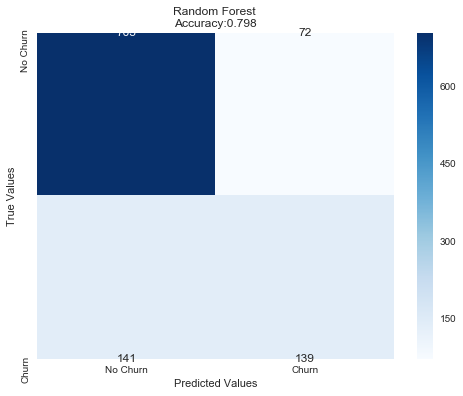

In [232]:
# Plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm,
                    index = target_names,
                    columns = target_names)
plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=True, fmt='g', cmap='Blues')
plt.title('Random Forest \nAccuracy:{0:.3f}'.format(accuracy_score(y_test, y_pred)))
plt.ylabel('True Values')
plt.xlabel('Predicted Values')
plt.show()

In [233]:
# Import the library for AUC and ROC curve
from sklearn.metrics import roc_curve, auc

In [234]:
# Create dictionary of the different classifiers created
models = [
    {
        'label':'Logistic Regression',
        'model': clf,
    },
    {
        'label': 'Decision Tree',
        'model': clf_tree,
    },
    {
        'label': 'SVM',
        'model': clf_svm,
    },
    {
        'label':'Random Forest Grid Search',
        'model': clf_random,
    }
    ]

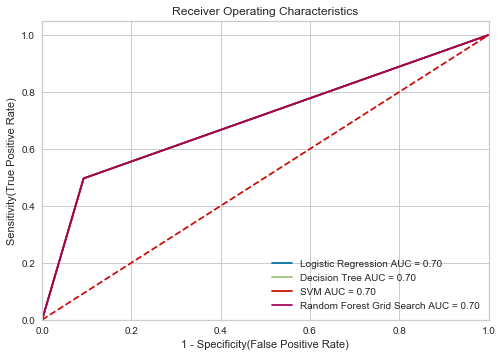

In [235]:
# Plot the ROC Curve
for m in models:
    model = m['model']
    model.fit(X_train[top18_features], y_train)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1)
    roc_auc = metrics.auc(fpr, tpr)
    plt.plot(fpr, tpr, label='%s AUC = %0.2f' % (m['label'], roc_auc))

plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.ylabel('Sensitivity(True Positive Rate)')
plt.xlabel('1 - Specificity(False Positive Rate)')
plt.title('Receiver Operating Characteristics')
plt.legend(loc="lower right")
plt.show()